# Кластеризация.

[Кластеризация](https://ru.wikipedia.org/wiki/%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%BD%D1%8B%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7) - это один из видов задач обучения без учителя. Задача заключается в разбиении всех объектов на группы похожих между собой объектов и сильно отличающихся от всех остальных. Так как строгого понятия похожести объектов как такового нет, то алгоритмов кластеризации много, да и каждый алгоритм имеет много вариантов работы.

![](http://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_0011.png)

## KMeans

Метод k-means - это один из наиболее популярных методов кластеризации. Основная идея метода заключается в том, что на каждой итерации пересчитывается центр масс (центроид) для каждого кластера, полученного на предыдущем шаге, затем объекты снова разбиваются на кластеры согласно тому, какой из новых центроидов находится ближе.
Более формально, алгоритм принимает на вход выборку $X_1, \dots, X_N$ и параметр $k$, указывающий необходимое число кластеров. Выходом алгоритма является набор из $k$ центроидов $\{\mu_1, \dots, \mu_k\}$, с помощью которых кластеризация осуществляется путём отнесения каждого объекту к ближайшему центроиду. Все точки внутри одного кластера ближе к центроиду этого кластера, чем к центроиду любого другого кластера.
Метод может быть сформулирован как задача оптимизации, а именно, минимизации суммарного квадратичного отклонения точек кластеров от центров этих кластеров по центроидам и кластерам: $$\sum_{i=1}^k \sum_{X_n \in C_i} ||X_n - \mu_i||^2 \rightarrow \min, \text{где $C_i$ - это $i$-ый кластер, $\mu_i$ - это центр масс кластера $C_i$.}$$
Решение такой задачи оптимизации является NP-трудной задачей, однако существует простой итеративный алгоритм, позволяющий найти локальный минимум указанного функционала. Алгоритм представляет собой последовательное чередование двух шагов до сходимости.
Предположим, что как-то (например, случайно) выбраны начальные положения центроидов $\mu_1, \dots, \mu_k$.

1. Этап кластеризации. На данном этапе происходит кластеризация выборки, как было описано выше: каждый объект относится к кластеру ближайшего к нему центроида. Формально, $$C_i = \{X_n : ||X_n - \mu_i|| \leq ||X_n - \mu_j||, \text{ для всех $j \in \{1, \dots, k\}$}\}.$$

2. Этап обновления центроидов. На данном этапе центроиды пересчитываются, как центры масс только что построенных кластеров. Формально, $$\mu_i = \frac{1}{|C_i|}\sum_{X_n \in C_i} X_n.$$

Этот процесс продолжается, пока центроиды и кластеризация продолжают изменяться. Алгоритм гарантированно сходится, однако не гарантируется достижение глобального минимума, а только одного из локальных минимумов. Другим недостатком алгоритма является то, что итоговая кластеризация зависит от выбора исходных центров кластеров. На практике алгоритм запускается несколько раз из различных начальных приближений, а полученные результаты некоторым образом усредняются. Стоит также отметить, что число кластеров необходимо знать заранее. Существуют различные эвристики, позволяющие выбирать в некотором смысле оптимальное число кластеров.

_определение взято из материалов курса [ODS](https://habrahabr.ru/company/ods/)_

### Литература

- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную

In [16]:
!pip install scikit-image

In [17]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import random 
from tqdm.notebook import tqdm
from skimage.io import imread

%matplotlib inline

# Зафиксируем случайность, чтобы у нас получались одинаковые результаты.
np.random.seed(seed=42)

## Рассмотрим как работает алгоритм кластеризации KMeans на синтетическом примере.

Бросим на плоскость случайно точки с разными параметрами случайности, чтобы образовались кластеры.

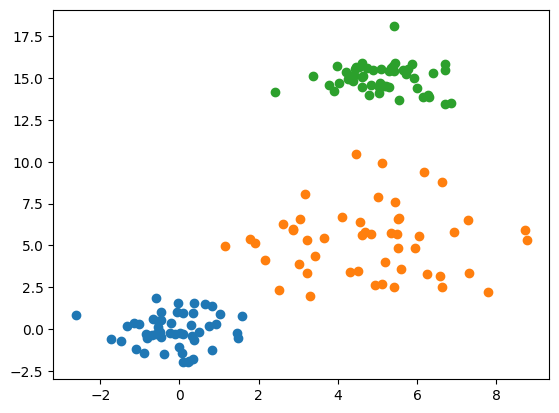

In [18]:
p1 = np.random.normal(loc=0, scale=1, size=(50,2))
p2 = np.random.normal(loc=5, scale=2, size=(50,2))
p3 = np.random.normal(loc=10, scale=0.8, size=(50,2)) - np.array([5, -5])

X = np.concatenate((p1, p2, p3))

plt.scatter(p1[:,0], p1[:, 1])
plt.scatter(p2[:,0], p2[:, 1])
plt.scatter(p3[:,0], p3[:, 1])

Нарисуем точки на плоскости, но без окрашивания точек. Так будет видеть данные алгоритм. Можем ли мы сами понять где и какие кластеры?

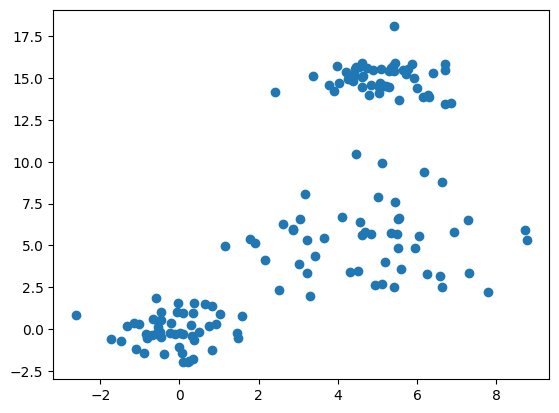

In [19]:
plt.scatter(X[:, 0], X[:, 1])

Рассмотрим пошагово работу алгоритма KMneans на основе обычного евклидова расстояния.  

_Пример из блога ODS: https://habrahabr.ru/company/ods/blog/325654/_

### Задание 1.1 
Напишите функцию, которая рассчитывает расстояния от центров кластеров до каждой точки и возвращает, к какому кластеру принадлежит каждая точка.

In [20]:
import numpy as np
from scipy.spatial.distance import cdist

def kmeans_predict(x, clusters):
    """
    Определяет, к какому кластеру принадлежит каждая точка.
    :param x: Массив точек (n_samples, n_features).
    :param clusters: Центры кластеров (n_clusters, n_features).
    :return: Массив меток кластеров для каждой точки.
    """
    # Вычисляем расстояния от каждой точки до каждого кластера
    distances = cdist(x, clusters, metric='euclidean')
    
    # Находим индекс ближайшего кластера для каждой точки
    labels = np.argmin(distances, axis=1)
    
    return labels

Проверяем что получилось

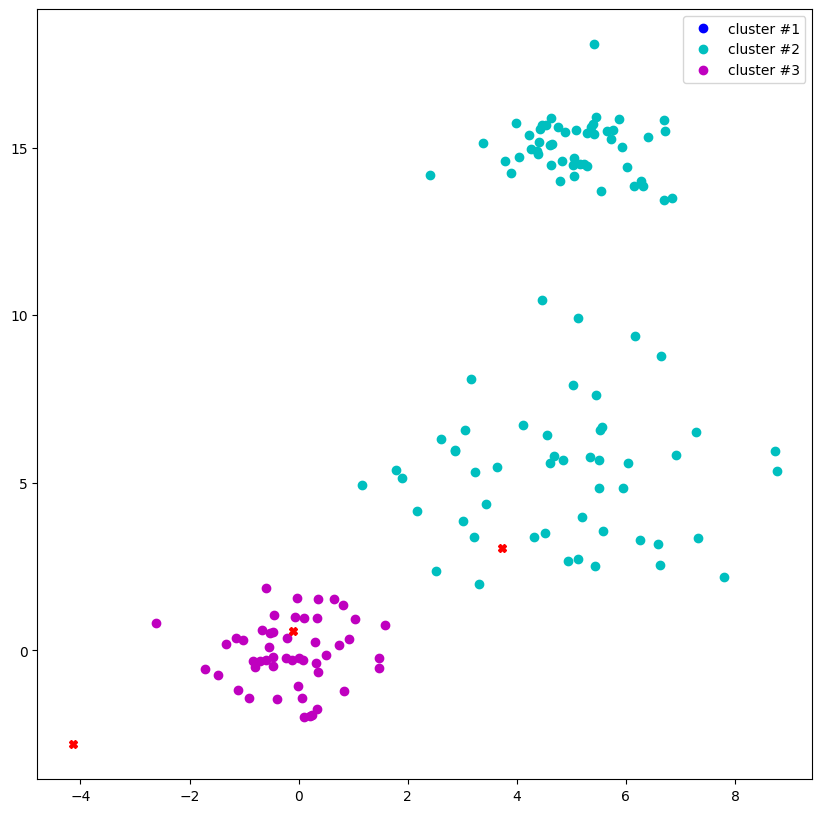

In [21]:
# Генерируем случайные координаты для центров кластеров
centroids = np.random.normal(loc=0.0, scale=5., size=6)
centroids = centroids.reshape((3, 2)) # итого получаем 3 точки в двумерном пространстве

plt.figure(figsize=(10, 10))
labels = kmeans_predict(X, centroids)

plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'bo', label='cluster #1')
plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'co', label='cluster #2')
plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'mo', label='cluster #3')
plt.plot(centroids[:, 0], centroids[:, 1], 'rX')
plt.legend(loc=0)

###  Задание 1.2 
Напишите код для обновления центров кластеров. Запоминайте центры кластеров $-$ это понадобится потом для визуализации.
Для упрощения каждому облачку данных заранее присвоим кластер.<br>
Положим в каждую новую центроиду геометрический центр её точек.<br>

In [22]:
centroids = np.random.normal(loc=0.0, scale=1., size=6).reshape((3, 2))

cent_history = [] # История центров кластеров
cent_history.append(centroids)

STEPS = 5 # количество шагов итерации обновления центров кластеров

for i in range(STEPS):

    # Определяем метки кластеров для каждой точки
    labels = kmeans_predict(X, centroids)
    
    # Обновляем центры кластеров
    new_centroids = np.zeros_like(centroids)
    for cluster_idx in range(centroids.shape[0]):
        # Находим точки, принадлежащие текущему кластеру
        cluster_points = X[labels == cluster_idx]
        if len(cluster_points) > 0:
            # Вычисляем новый центр как среднее арифметическое точек кластера
            new_centroids[cluster_idx] = np.mean(cluster_points, axis=0)
        else:
            # Если кластер пуст, оставляем центр без изменений
            new_centroids[cluster_idx] = centroids[cluster_idx]
    
    # Обновляем центры
    centroids = new_centroids
    
    # Сохраняем текущие центры в историю
    cent_history.append(centroids)

А теперь нарисуем всю эту красоту

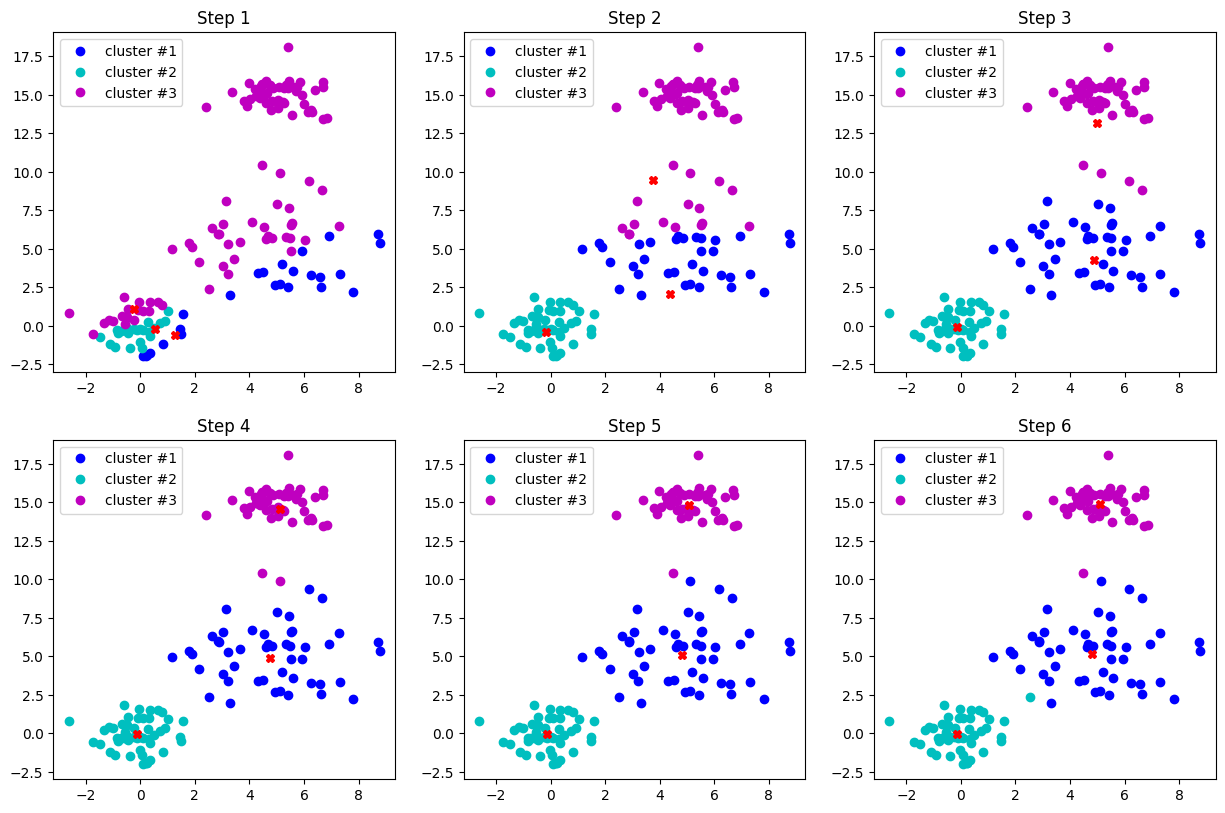

In [23]:
plt.figure(figsize=(15, 15))
for i in range(STEPS + 1):
    labels = kmeans_predict(X, cent_history[i])

    plt.subplot((STEPS + 1) // 2, (STEPS + 1) // 2, i + 1)
    plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'bo', label='cluster #1')
    plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'co', label='cluster #2')
    plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'mo', label='cluster #3')
    plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], 'rX')
    plt.legend(loc=0)
    plt.title('Step {:}'.format(i + 1))

Обратите внимание, последние 3 шага уже не сильно изменили координаты центров кластеров и состав кластеров.

### 1.3 Напишите функцию обучения kMeans, которая возвращает центры кластеров и к какому кластеру принадлежит каждая точка. 

* k - кол-во кластеров
* max_iter - через сколько итераций остановится
* tol - если сумма расстояний между прошлыми центрами кластеров и новыми центрами меньше tol, то остановиться
* low и high - это минимально и максимально значение которое могут принимать точки центров кластеров при генерации

In [24]:
def kmeans_fit_predict(x, k=8, max_iter=100, tol=0.1, low=0.0, high=1.0):
    """
    Обучает модель K-средних и возвращает центры кластеров и метки точек.
    :param x: Массив точек (n_samples, n_features).
    :param k: Количество кластеров.
    :param max_iter: Максимальное количество итераций.
    :param tol: Порог для остановки (если изменение центров меньше tol).
    :param low: Минимальное значение для генерации центров.
    :param high: Максимальное значение для генерации центров.
    :return: Центры кластеров и метки точек.
    """
    # Инициализация центров кластеров случайным образом
    n_samples, n_features = x.shape
    clusters = np.random.uniform(low=low, high=high, size=(k, n_features))
    
    # История центров для вычисления loss
    prev_clusters = np.zeros_like(clusters)
    
    # Основной цикл
    for i in range(max_iter):
        # Шаг 1: Определяем метки кластеров для каждой точки
        distances = cdist(x, clusters, metric='euclidean')
        labels = np.argmin(distances, axis=1)
        
        # Шаг 2: Обновляем центры кластеров
        for cluster_idx in range(k):
            # Находим точки, принадлежащие текущему кластеру
            cluster_points = x[labels == cluster_idx]
            if len(cluster_points) > 0:
                # Вычисляем новый центр как среднее арифметическое точек кластера
                clusters[cluster_idx] = np.mean(cluster_points, axis=0)
            else:
                # Если кластер пуст, генерируем новый случайный центр
                clusters[cluster_idx] = np.random.uniform(low=low, high=high, size=(n_features,))
        
        # Шаг 3: Вычисляем loss (изменение центров)
        loss = np.linalg.norm(clusters - prev_clusters)
        
        # Выводим информацию о текущей итерации
        print(f"Итерация {i + 1}, Loss: {loss:.4f}")
        
        # Проверяем условие остановки
        if loss < tol:
            print(f"Обучение завершено на итерации {i + 1} (loss < tol).")
            break
        
        # Сохраняем текущие центры для следующей итерации
        prev_clusters = clusters.copy()
    
    # Возвращаем центры кластеров и метки точек
    return clusters, labels

Проверим работу на точках: воспользуемся kmeans_fit_predict и построим график для результата предсказания кластеров. 

In [25]:
# установим число кластеров k равное трем
# не генерируем центр кластера выше максимального значения из Х - ограничим это используя high
clusters_mnist, labels_mnist = kmeans_fit_predict(X, k=3, low=0.0, high=np.max(X))

Итерация 1, Loss: 15.5826
Итерация 2, Loss: 7.4248
Итерация 3, Loss: 2.4812
Итерация 4, Loss: 0.7511
Итерация 5, Loss: 0.1291
Итерация 6, Loss: 0.0000
Обучение завершено на итерации 6 (loss < tol).


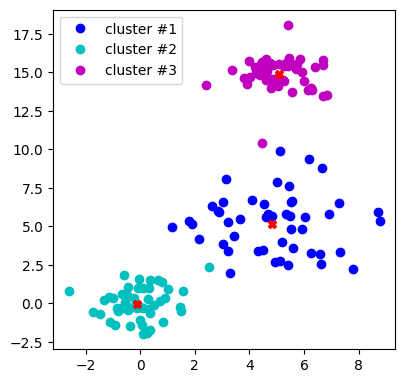

In [26]:

plt.figure(figsize=(15, 15))
plt.subplot((STEPS + 1) // 2, (STEPS + 1) // 2, i + 1)
plt.plot(X[labels_mnist == 0, 0], X[labels_mnist == 0, 1], 'bo', label='cluster #1')
plt.plot(X[labels_mnist == 1, 0], X[labels_mnist == 1, 1], 'co', label='cluster #2')
plt.plot(X[labels_mnist == 2, 0], X[labels_mnist == 2, 1], 'mo', label='cluster #3')
plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], 'rX')
plt.legend(loc=0)

## MNIST

Рассмотрим датасет рукописных цифр MNIST, с которым мы уже работали в задании по KNN.



In [27]:
from sklearn import datasets

X, y = datasets.load_digits(return_X_y=True)

print("Экземпляров: {}\nРазмер изображения: {}x{}".format(X.shape[0], np.sqrt(X.shape[1]), np.sqrt(X.shape[1])))

Экземпляров: 1797
Размер изображения: 8.0x8.0


Подумайте, как можно использовать kmeans для классификации

**Ваш ответ:**


Натренируйте kMeans используя функцию `kmeans_fit_predict()`, выберите high и low (как в примере с точками). Выберите подходящее число кластеров

In [28]:
clusters_mnist, labels_mnist = kmeans_fit_predict(X, k=10, max_iter=100, tol=0.001, low=0.0, high=1.0)

# Выводим результаты
print("Центры кластеров:")
print(clusters_mnist)
print("Метки точек:")
print(labels_mnist)

Итерация 1, Loss: 117.7889
Итерация 2, Loss: 21.1719
Итерация 3, Loss: 11.7723
Итерация 4, Loss: 8.9238
Итерация 5, Loss: 7.5645
Итерация 6, Loss: 7.6918
Итерация 7, Loss: 7.6680
Итерация 8, Loss: 7.3672
Итерация 9, Loss: 7.3478
Итерация 10, Loss: 7.4448
Итерация 11, Loss: 7.3870
Итерация 12, Loss: 7.1173
Итерация 13, Loss: 7.2553
Итерация 14, Loss: 7.0205
Итерация 15, Loss: 7.3187
Итерация 16, Loss: 7.6062
Итерация 17, Loss: 7.0905
Итерация 18, Loss: 7.2273
Итерация 19, Loss: 7.3957
Итерация 20, Loss: 6.8904
Итерация 21, Loss: 7.1146
Итерация 22, Loss: 7.2337
Итерация 23, Loss: 6.7232
Итерация 24, Loss: 7.0951
Итерация 25, Loss: 6.9471
Итерация 26, Loss: 6.9635
Итерация 27, Loss: 6.9529
Итерация 28, Loss: 7.0091
Итерация 29, Loss: 7.7229
Итерация 30, Loss: 7.3409
Итерация 31, Loss: 7.1424
Итерация 32, Loss: 7.4176
Итерация 33, Loss: 7.4183
Итерация 34, Loss: 7.4001
Итерация 35, Loss: 7.6327
Итерация 36, Loss: 7.5848
Итерация 37, Loss: 7.5611
Итерация 38, Loss: 7.4757
Итерация 39, Loss

Проверим. Выведем 10 точек из какого нибудь кластера и посмотрим, что они соотвествуют одной цифре.

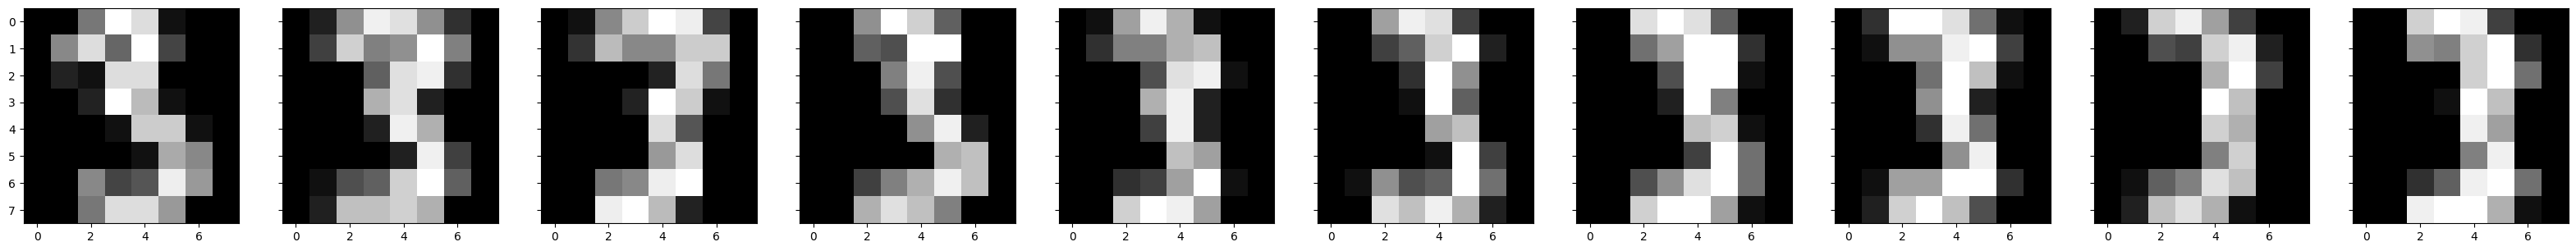

In [29]:
number = 3 # Номер кластера
count = 10 # Кол-во примеров
testX = X[y == number]

testX[0,:].reshape([8,8])
f, axes = plt.subplots(1, count, sharey=True, figsize=(40,6))
for i in range(count):
    axes[i].imshow(testX[i,:].reshape([8,8]), cmap='gray')

## Центры кластеров фотографий

Можно найти центры кластеров по фотографиям людей.

Возьмем фото 12 разных людей и разобьем их на кластеры. Так можно решать, например, задачу идентификации людей. Можно добавлять новое лицо и, не переобучая kmeans, определять, кто на этой фотографии (к какому кластеру относится картинка).

In [30]:
# загрузим датасет с фотографиями знаменитостей
from sklearn import datasets
lfw_people = datasets.fetch_lfw_people(min_faces_per_person=50, resize=0.4)

Ariel Sharon: 77 photos.
Colin Powell: 236 photos.
Donald Rumsfeld: 121 photos.
George W Bush: 530 photos.
Gerhard Schroeder: 109 photos.
Junichiro Koizumi: 60 photos.
Tony Blair: 144 photos.


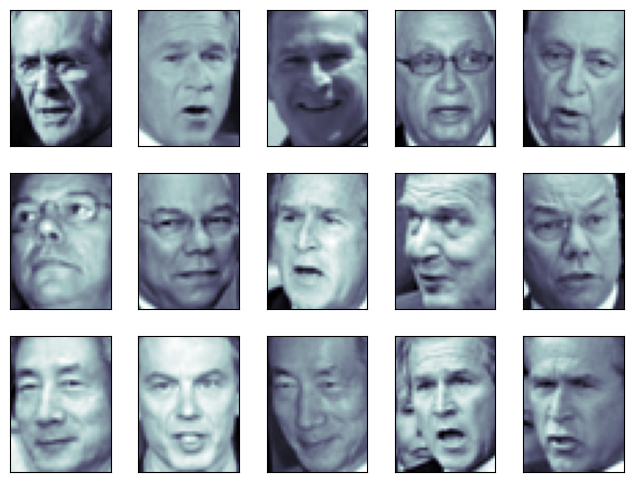

In [31]:
fig = plt.figure(figsize=(8, 6))

for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(lfw_people.images[i], cmap='bone')

for i, name in enumerate(lfw_people.target_names):
    print("{}: {} photos.".format(name, (lfw_people.target == i).sum()))

### 3.1 Натренируйте kMeans и нарисуйте центры кластеров как картинки выше.

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler

def kmeans_fit_predict(x, k=8, max_iter=100, tol=0.1, low=0.0, high=1.0):
    # Инициализация центров кластеров
    clusters = np.random.uniform(low=low, high=high, size=(k, x.shape[1]))
    prev_clusters = np.zeros_like(clusters)
    
    for i in range(max_iter):
        # Определяем метки кластеров
        distances = cdist(x, clusters, metric='euclidean')
        labels = np.argmin(distances, axis=1)
        
        # Обновляем центры кластеров
        new_clusters = np.zeros_like(clusters)
        for cluster_idx in range(k):
            cluster_points = x[labels == cluster_idx]
            if len(cluster_points) > 0:
                new_clusters[cluster_idx] = np.mean(cluster_points, axis=0)
            else:
                new_clusters[cluster_idx] = np.random.uniform(low=low, high=high, size=(x.shape[1],))
        
        # Выводим центры кластеров на каждой итерации
        print(f"Итерация {i + 1}, Центры кластеров:")
        print(new_clusters)
        
        # Проверяем условие остановки
        loss = np.linalg.norm(new_clusters - prev_clusters)
        if loss < tol:
            print(f"Обучение завершено на итерации {i + 1} (loss < tol).")
            break
        
        prev_clusters = new_clusters.copy()
        clusters = new_clusters
    
    return clusters, labels

Итерация 1, Центры кластеров:
[[0.33739614 0.32107383 0.3180837  ... 0.57163393 0.56065357 0.55816996]
 [0.33191117 0.85639742 0.09299171 ... 0.73728801 0.19316418 0.23986012]
 [0.48393852 0.49419522 0.51942611 ... 0.41550282 0.3431946  0.27304217]
 ...
 [0.34447902 0.34653786 0.37812811 ... 0.38147315 0.3624596  0.34696162]
 [0.29392555 0.31181678 0.36239639 ... 0.48571423 0.48436043 0.45616254]
 [0.31807289 0.33919826 0.38370359 ... 0.5586645  0.53096634 0.52110934]]
Итерация 2, Центры кластеров:
[[0.30489635 0.2931616  0.30853122 ... 0.49616674 0.47380322 0.40960965]
 [0.0563088  0.07530373 0.15435496 ... 0.23612727 0.20923333 0.76721221]
 [0.46557474 0.46810615 0.49527669 ... 0.43948093 0.36525536 0.31923839]
 ...
 [0.33292547 0.32708436 0.35911673 ... 0.34916484 0.32387793 0.31902692]
 [0.31511509 0.32478544 0.3498328  ... 0.41809607 0.41375387 0.41934642]
 [0.34168056 0.35305601 0.38299599 ... 0.51227885 0.48988235 0.47053605]]
Итерация 3, Центры кластеров:
[[0.28830174 0.2800206

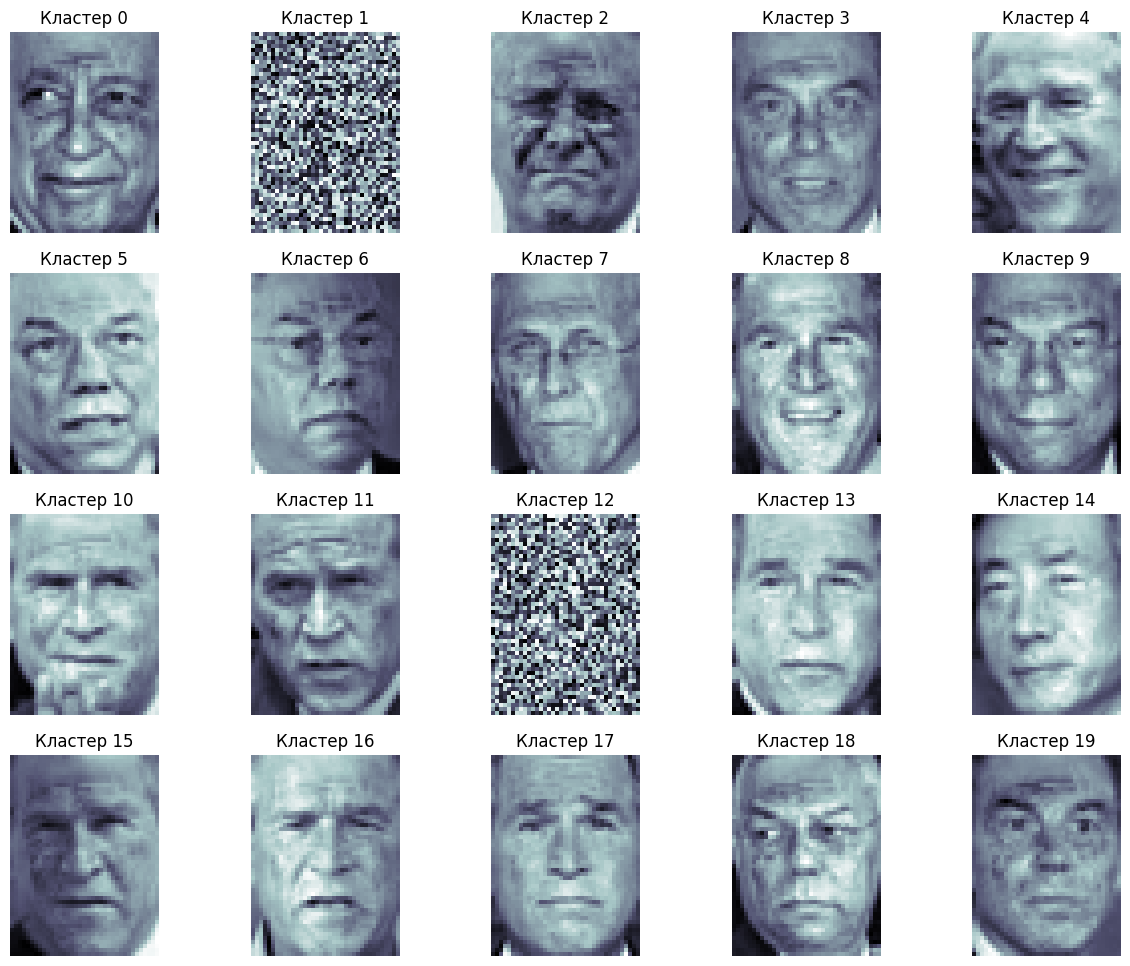

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler

# Загружаем данные LFW
lfw_people = datasets.fetch_lfw_people(min_faces_per_person=50, resize=0.4)

# Нормализуем данные (значения пикселей от 0 до 1)
scaler = MinMaxScaler()
x_lfw = scaler.fit_transform(lfw_people.data)

# Выбираем параметры
k = 20  # Количество кластеров
low = 0.0  # Минимальное значение пикселя
high = 1.0  # Максимальное значение пикселя
max_iter = 300  # Количество итераций
tol = 0.01  # Порог для остановки

# Обучаем модель K-средних
clusters_lfw, labels_lfw = kmeans_fit_predict(x_lfw, k=k, max_iter=max_iter, tol=tol, low=low, high=high)

# Находим медиоиды (ближайшие к центрам изображения)
medoids = []
for cluster_idx in range(k):
    # Находим все точки, принадлежащие текущему кластеру
    cluster_points = x_lfw[labels_lfw == cluster_idx]
    
    if len(cluster_points) > 0:
        # Вычисляем расстояния от центра кластера до всех точек кластера
        distances = cdist(cluster_points, [clusters_lfw[cluster_idx]], metric='euclidean').flatten()
        
        # Находим индекс точки с минимальным расстоянием (медиоид)
        medoid_idx = np.argmin(distances)
        
        # Выбираем медиоид
        medoid = cluster_points[medoid_idx]
        medoids.append(medoid)
    else:
        # Если кластер пуст, добавляем случайное изображение
        medoids.append(np.random.uniform(low=low, high=high, size=x_lfw.shape[1]))

# Преобразуем медиоиды в форму изображения
medoid_images = np.array(medoids).reshape(k, 50, 37)

# Визуализация медиоидов
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
for i, ax in enumerate(axes.ravel()):
    if i < k:
        ax.imshow(medoid_images[i], cmap='bone')  # Используем правильную цветовую карту
        ax.set_title(f'Кластер {i}')
        ax.axis('off')
plt.show()

## Визуализация 64-мерного пространства, используя PCA и TSNE

Просто так визуализировать 64-мерный объект не получится, нам нужно уменьшить его размерность до 2, чтобы он укладывался на плоскость.

Существует специальный алгоритм PCA - Метод главных компонент.

![](http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png)

Далее мы будем использовать библиотеку [scikit-learn](http://scikit-learn.org/). По сути это библиотека-набор разных алгоритмов анализа данных, машинного обучения.

Документация по библиотеке всегда доступна:
- по ? в jupyter
- по комбинации shift-tab в jupyter
- на сайте http://scikit-learn.org/stable/documentation.html

Просто так визуализировать 64-мерный объект не получится, нам нужно уменьшить его размерность до 2, чтобы он укладывался на плоскость.

Существует специальный алгоритм PCA -  [Метод главных компонент](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%B3%D0%BB%D0%B0%D0%B2%D0%BD%D1%8B%D1%85_%D0%BA%D0%BE%D0%BC%D0%BF%D0%BE%D0%BD%D0%B5%D0%BD%D1%82).

Нарисуем scatter plot для тренировочной выборки: на графике у нас будут точки, помеченные лейблом - цифрой которую обозначает эта точка в пространстве.

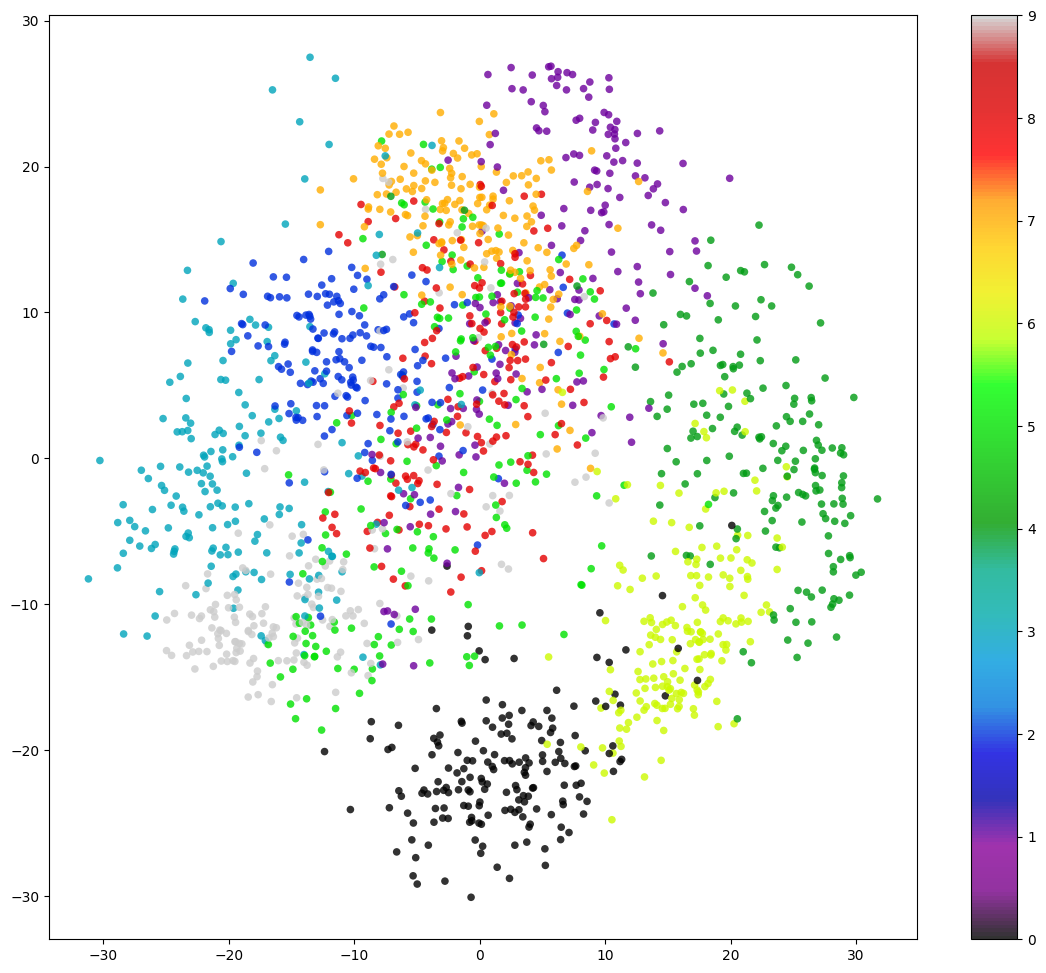

In [40]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42) # 2 компоненты, значит 2-мерное представление

X_reduced = pca.fit_transform(X)
plt.figure(figsize=(14,12))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap=plt.cm.nipy_spectral, edgecolor='none', alpha=0.8, s=30)
plt.colorbar()

А теперь посмотрим как расставил границы наш алгоритм KMeans. Как видим - хоть цвета и перепутаны, но сами кластеры угадываются.

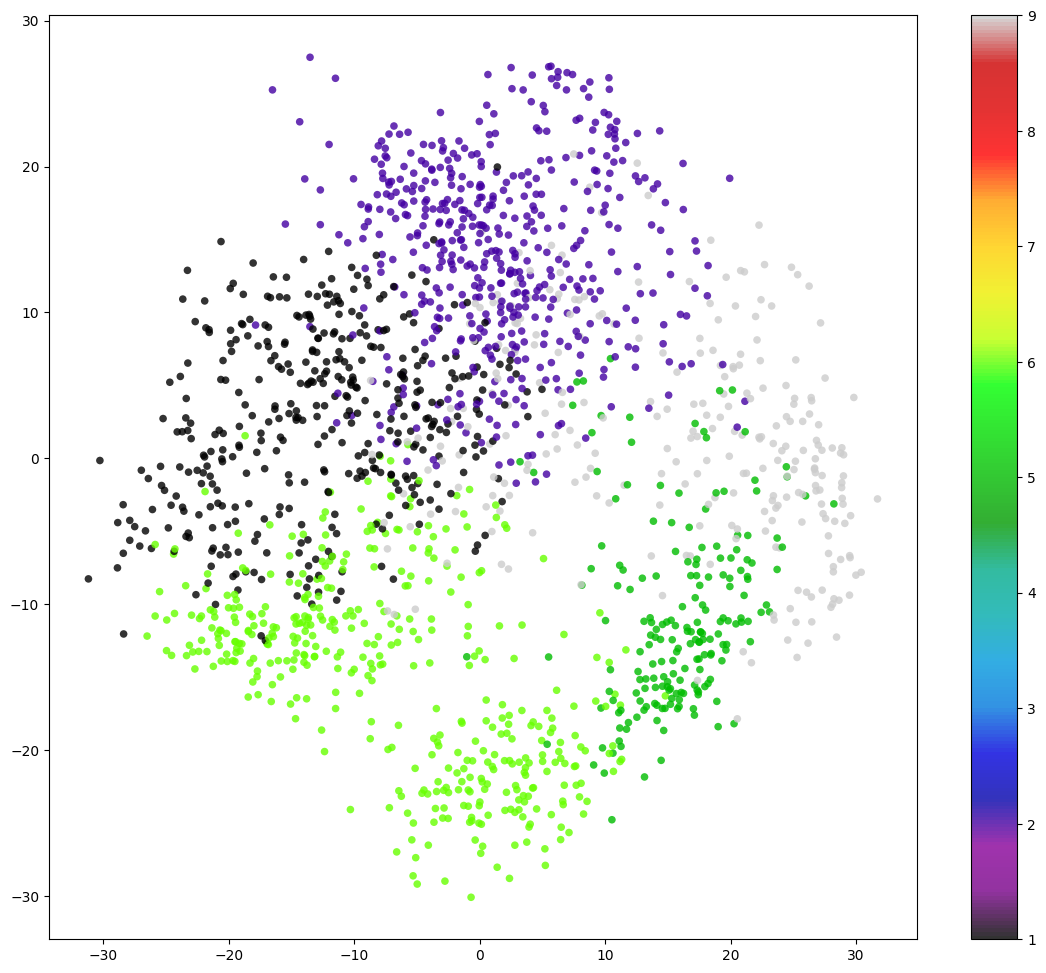

In [43]:
plt.figure(figsize=(14,12))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels_mnist, cmap=plt.cm.nipy_spectral,  edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()

Центры кластеров представляют из себя нечто среднее, окруженное максимально "похожими" на них элементами. Поэтому мы можем предположить, что на визуализации, центры кластеров будут похожи на цифры.

Центры кластеров можно получить у модели лежат в `clusters_mnist`.

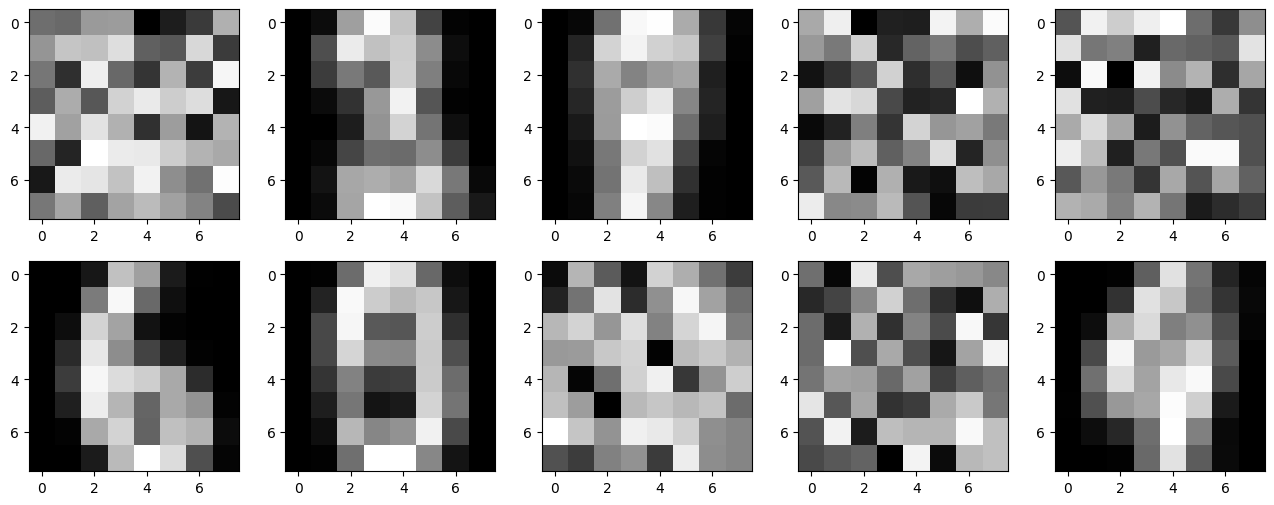

In [44]:
plt.figure(figsize=(16, 6))

for i, center in enumerate(clusters_mnist):
    plt.subplot(2, 5, i + 1)
    plt.imshow(center[:].reshape([8,8]), cmap='gray')

Существуют и другие методы понижения размерности, например t-SNE, но он намного медленнее чем PCA.

Мы пока что не изучаем как именно работают PCA и tSNE, просто восхтимся их способностями.

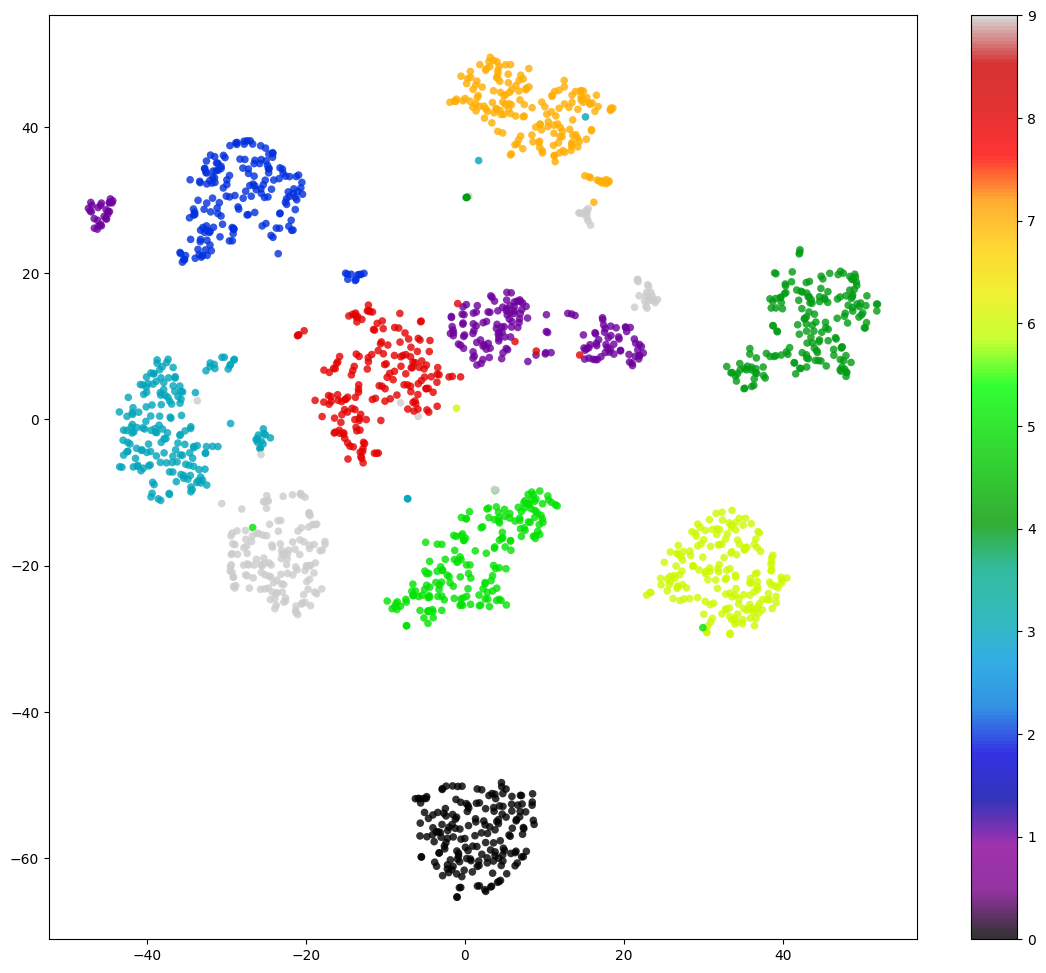

In [46]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca', random_state=42)
X_reduced_t = tsne.fit_transform(X)

plt.figure(figsize=(14,12))
plt.scatter(X_reduced_t[:,0], X_reduced_t[:,1], c=y, cmap=plt.cm.nipy_spectral,
            edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()

Теперь нарисуем тот же scatter-plot, только на основе лейблов из kMeans. Ожидаем что кластеры будут покрашены в нужные цвета.

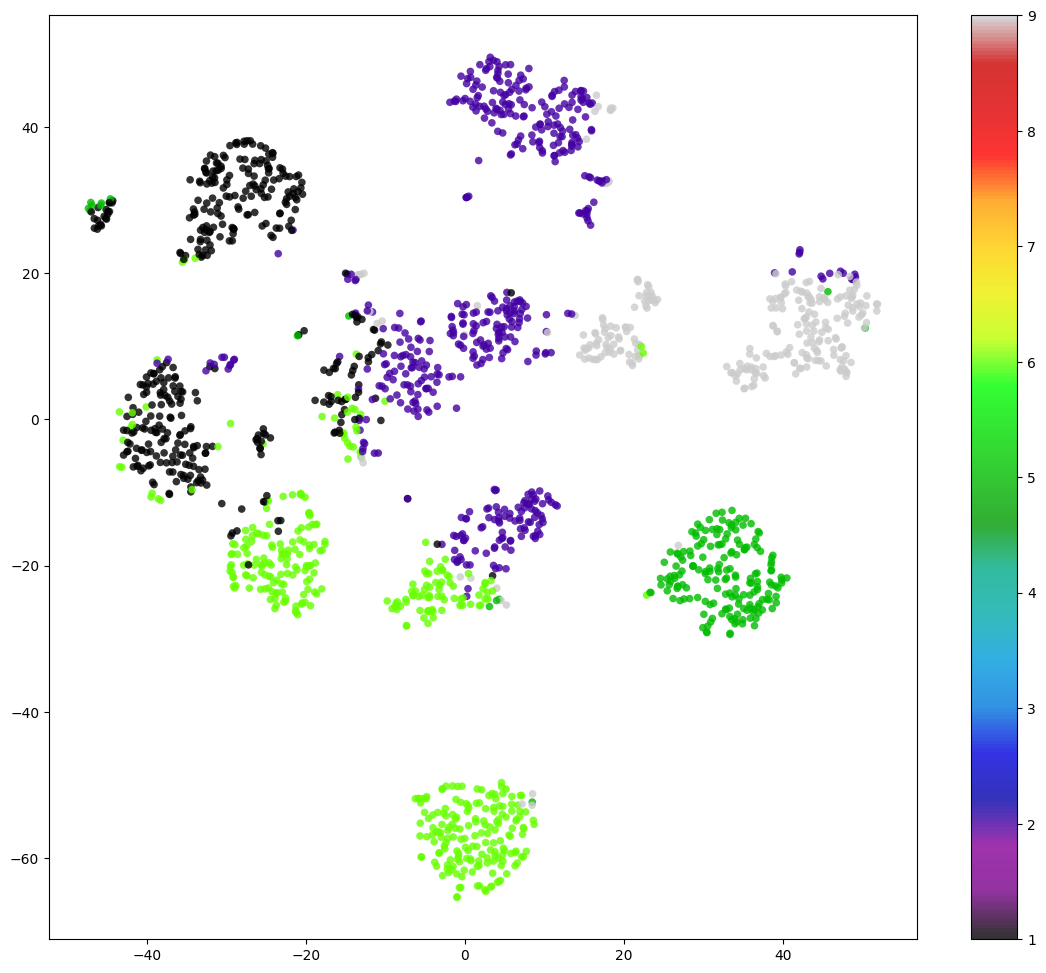

In [48]:
plt.figure(figsize=(14,12))
plt.scatter(X_reduced_t[:,0], X_reduced_t[:,1], c=labels_mnist, cmap=plt.cm.nipy_spectral,
            edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()